In [1]:
import re
import scipy
from numpy import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dense

from sklearn.svm import LinearSVC
from sklearn import preprocessing,svm
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support

Using TensorFlow backend.


### Read Files

In [2]:
train_df=pd.read_csv('UNSW_2018_IoT_Botnet_Final_10_best_Training.csv')
test_df=pd.read_csv('UNSW_2018_IoT_Botnet_Final_10_best_Testing.csv')

In [3]:
train_df.head()

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,udp,192.168.100.150,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.0,0.494549,4.031619,1,DDoS,UDP
1,2432264,tcp,192.168.100.150,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.0,0.256493,4.012924,1,DDoS,TCP
2,1976315,tcp,192.168.100.147,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.0,0.294880,3.609205,1,DDoS,TCP
3,1240757,udp,192.168.100.150,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.0,0.461435,4.942302,1,DoS,UDP
4,3257991,udp,192.168.100.147,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.0,1.002999,4.994452,1,DDoS,UDP


In [4]:
test_df.head()

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,792371,udp,192.168.100.150,48516,192.168.100.3,80,175094,0.226784,100,4.100436,4,4.457383,100,0.000000,0.404711,4.719438,1,DoS,UDP
1,2056418,tcp,192.168.100.148,22267,192.168.100.3,80,143024,0.451998,100,3.439257,1,3.806172,100,0.225077,0.401397,4.442930,1,DDoS,TCP
2,2795650,udp,192.168.100.149,28629,192.168.100.3,80,167033,1.931553,73,0.000000,4,2.731204,100,0.000000,0.407287,4.138455,1,DDoS,UDP
3,2118009,tcp,192.168.100.148,42142,192.168.100.3,80,204615,0.428798,56,3.271411,1,3.626428,100,0.000000,0.343654,4.229700,1,DDoS,TCP
4,303688,tcp,192.168.100.149,1645,192.168.100.5,80,40058,2.058381,100,0.000000,3,1.188407,100,0.000000,0.135842,4.753628,1,DoS,TCP


### prepocessing

In [5]:
main_df=pd.concat([train_df,test_df])
main_df

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,udp,192.168.100.150,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.000000,0.494549,4.031619,1,DDoS,UDP
1,2432264,tcp,192.168.100.150,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.000000,0.256493,4.012924,1,DDoS,TCP
2,1976315,tcp,192.168.100.147,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.000000,0.294880,3.609205,1,DDoS,TCP
3,1240757,udp,192.168.100.150,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.000000,0.461435,4.942302,1,DoS,UDP
4,3257991,udp,192.168.100.147,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.000000,1.002999,4.994452,1,DDoS,UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733700,1571905,udp,192.168.100.148,17412,192.168.100.6,80,168162,1.743940,39,0.000000,4,3.020449,39,0.000000,0.224603,4.043432,1,DoS,UDP
733701,2787099,udp,192.168.100.147,932,192.168.100.3,80,158482,0.694618,65,3.002272,4,3.905409,100,0.000000,0.875121,4.691634,1,DDoS,UDP
733702,2255382,tcp,192.168.100.149,47980,192.168.100.3,80,79841,1.744651,53,0.000000,1,2.464288,100,0.278496,0.472773,3.802142,1,DDoS,TCP
733703,588946,tcp,192.168.100.147,25096,192.168.100.7,80,63165,0.000000,100,0.000000,3,0.000000,100,0.000000,0.070461,0.000000,1,DoS,TCP


In [6]:
main_df.columns

Index(['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev',
       'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max', 'attack', 'category', 'subcategory'],
      dtype='object')

In [7]:
ndf=main_df[['seq', 'stddev',
       'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max','attack', 'category']]

In [8]:
X=ndf.iloc[:,:-2]
y=ndf.iloc[:,-2]

### train_test_split

In [9]:
import sklearn

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

### Model

In [10]:

# define the keras model
model = Sequential()
model.add(Dense(20, input_dim=10, activation='tanh'))
model.add(Dense(60, input_dim=20, activation='tanh'))
model.add(Dense(80, input_dim=60, activation='tanh'))
model.add(Dense(90, input_dim=80, activation='tanh'))
model.add(Dense(1, input_dim=90, activation='sigmoid'))
# model.add(Dense(80, input_dim=60, activation='relu'))
# model.add(Dense(80, input_dim=60, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))


In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4880      
_________________________________________________________________
dense_4 (Dense)              (None, 90)                7290      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 91        
Total params: 13,741
Trainable params: 13,741
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=2, batch_size=256)

Train on 2934817 samples, validate on 733705 samples
Epoch 1/2
2934817/2934817 [==============================] - 19s 7us/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0012 - val_accuracy: 0.9999
Epoch 2/2
2934817/2934817 [==============================] - 19s 6us/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.0012 - val_accuracy: 0.9999


### plotting

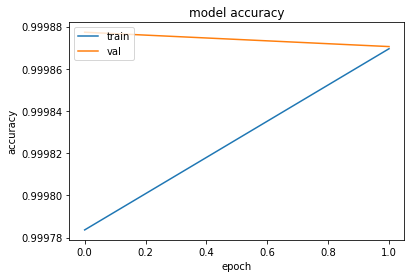

In [14]:
import keras
from matplotlib import pyplot as plt
# history = model.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

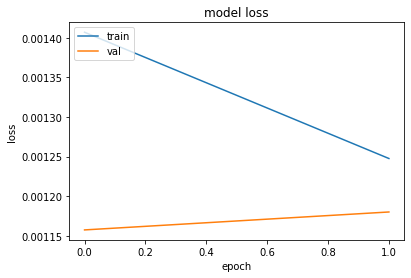

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### save model

In [16]:
model.save('trained_dense_model.h5')

In [17]:
import keras
import tensorflow as tf
from keras.models import load_model
model =tf.keras.models.load_model('trained_dense_model.h5')

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 99.99%
